In [25]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../charm/") 
sys.path.append(src_path)
# sys.path.append(root_dir)
# from combined_models import *
# from all_models import *
from charm import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
test_id = 0
# run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128.yaml'
run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
# ns_d = 384
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
# z_all_FP = z_all_FP[:-1]
z_all_FP = z_all_FP
ns_h = config_sims['ns_h']
# ns_h = 384
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params


device_id = torch.device("cuda")
ndim_diff = Nmax - 1

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
num_cond_Ntot = num_cond
mu_all = np.arange(Nmax + 1) + 1
sig_all = sigv * np.ones_like(mu_all)
ngauss_Nhalo = Nmax + 1

model_BinaryMask = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=2,
    mu_all=mu_all[:2],
    sig_all=sig_all[:2],
    base_dist=base_dist_Ntot,
    device=device_id
    )

# model_BinaryMask.to(dev)


model_multiclass = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=ngauss_Nhalo - 1,
    mu_all=mu_all[1:] - 1,
    sig_all=sig_all[1:],
    base_dist=base_dist_Ntot,
    device=device_id
    )


# model_multiclass.to(dev)


num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

model_M1 = NSF_1var_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf,
    device=device_id 
    )

ndim_diff = Nmax - 1
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Autoreg_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )


ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_BinaryMask,
    model_multiclass,
    ndim,
    ksize,
    ns_d,
    ns_h,
    1,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Binary_cond=True,
    sep_MultiClass_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Binary = num_cond_Ntot,
    num_cond_MultiClass = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    ).to(device_id)

# model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

model = torch.nn.DataParallel(model)


ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0/'

checkpoint = torch.load(ldir_cp + f'test_model_bestfit_6484.pth', map_location=device_id)
# print(iter)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()



ldir_f = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/2gpc/'

n_dim_red = (nf - 1) // 2
n_pad = n_dim_red * nc

z_REDSHIFT = float(z_all_FP[-1].split('_')[1])
if z_REDSHIFT == 0.0:
    z_REDSHIFT = 0

df_zg = pk.load(open(ldir_f + '%d/density_HR_full_m_res_256_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_id,'rb'))
df_test_zg = df_zg['density_cic_unpad_combined']
df_load = pk.load(open(
    ldir_f + '/' + str(test_id) + '/velocity_HR_full_m_res_256_z=' + str(z_REDSHIFT) + '_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
    )

vel_all = df_load['velocity_cic_unpad_combined']

df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')



vel_pad = np.stack([np.pad(vel_all[j,...], n_pad, 'wrap') for j in range(3)], axis=0)

df_test_all_pad = np.concatenate([np.log(1 + df_test_pad_zg + 1e-10)[None,...], vel_pad], axis=0)[None, None,:]
# 
df_test_all_unpad = np.concatenate([np.log(1 + df_test_zg + 1e-10)[None,...], vel_all], axis=0)[None, None,:]




/tmp/ipykernel_3395862/866836436.py:106: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_3395862/866836436.py:111: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [29]:
lgMmin, lgMmax


(12.7, 15.5)

In [30]:
def batch_cube(x, Nsub, width, stride):
    """Batches a cube x into Nsub sub-cubes per side, with width and stride."""
    batches = []
    for i in range(Nsub):
        for j in range(Nsub):
            for k in range(Nsub):
                batches.append(x[...,i*stride:i*stride+width,
                                 j*stride:j*stride+width,
                                 k*stride:k*stride+width])
    return np.stack(batches, axis=0)



In [31]:
Nsub = 256 // 128
Npix = 128
Npad = Npix + 2*n_pad
batch_rho = batch_cube(df_test_all_unpad, Nsub, Npix, Npix)
batch_rho_pad = batch_cube(df_test_all_pad, Nsub, Npad, Npix)



In [32]:
# Nsub


In [33]:
def get_halo_mock(df_test_all_pad, df_test_all_unpad):

    cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
    nsims_test = cond_nsh_test.shape[1]
    nax_h_test = cond_nsh_test.shape[2]
    ninp_test = cond_nsh_test.shape[-1]
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(device_id)    

    # cond_tensor_nsh_test.shape
    # LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
    # LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
    # fid_cosmo_val_all = LH_cosmo_val_all[test_id]
    fid_cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])  
    # params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}    

    cosmo_val_test = np.tile(fid_cosmo_val_all, (cond_tensor_nsh_test.shape[1] ,1))[None,:]

    # cosmo_val_test.shape
    # df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
    df_test_all_pad = torch.tensor(df_test_all_pad).to(device_id)
    df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
    cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(device_id)


    train_Ntot, train_M1, train_Mdiff = 1, 1, 1
    train_binary, train_multi = 1, 1
    # if verbose:
        # print(f"Running the model")

    # run the model
    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, _ = model.module.inverse(
        cond_x=df_test_all_pad,
        cond_x_nsh=df_test_all_unpad,
        cond_cosmo=cosmo_val_test,
        use_truth_Nhalo=1-train_Ntot,
        use_truth_M1=1-train_M1,
        use_truth_Mdiff=1-train_Mdiff,
        mask_Mdiff_truth=None,
        mask_M1_truth=None,
        Nhalos_truth=None,
        M1_truth=None,
        Mdiff_truth=None,
        train_binary=train_binary,
        train_multi=train_multi,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
    )


    BoxSize=1000

    Ntot_samp_test = Ntot_samp_test[0][:, np.newaxis]
    save_subvol_Nhalo = Ntot_samp_test.reshape(
        nsims_test, nax_h_test, nax_h_test, nax_h_test)
    save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
    save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

    mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(
        nsims_test, nax_h_test, nax_h_test, nax_h_test)[..., None]
    mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy(
    ).reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
    mask_subvol_Mtot = np.concatenate(
        [mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)

    # compute the mass of halos from output
    save_subvol_Mtot = np.zeros(
        (nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
    # Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (
                save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
        else:
            save_subvol_Mtot[...,
                                jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)

    save_subvol_Mtot *= mask_subvol_Mtot

    Nhalos = save_subvol_Nhalo[0, ...]  # histogram of halos in each voxel
    M_halos = save_subvol_Mtot[0, ...]  # mass of halos in each voxel
    M_halos_sort_norm = rescale_sub + (M_halos - lgMmin)/(lgMmax - lgMmin)
    M_halos_sort_norm *= mask_subvol_Mtot[0, ...]
    M_halos_sort_norm_condvel = M_halos_sort_norm.reshape(nax_h_test**3, -1)
    # create the meshgrid
    xall = (np.linspace(0, BoxSize, ns_h + 1))
    xarray = 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    # record discrete halo positions and masses
    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    # Nmax_sel = 3
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                Nh_vox = int(Nhalos[jx, jy, jz])
                if Nh_vox > 0:
                    x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))

                    lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                    k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')
    return pos_h_mock, lgMass_mock






In [34]:
lgMmin_cut = 13.7
hposs_all, lgMass_all = [], []
for i in range(len(batch_rho)):
    hpos, hmass = get_halo_mock(batch_rho_pad[i,...], batch_rho[i,...])
    mask = hmass > lgMmin_cut
    hposs_all.append(hpos[mask])
    lgMass_all.append(hmass[mask])

Lcharm = 1000.
l = 0
for i in range(Nsub):
    for j in range(Nsub):
        for k in range(Nsub):
            hposs_all[l] += np.array([i, j, k])*Lcharm
            l += 1

# Combine the outputs
pos_h_mock, lgMass_mock = np.concatenate(hposs_all), np.concatenate(lgMass_all)




/tmp/ipykernel_3395862/1878432971.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)


In [35]:
import matplotlib.pyplot as pl
import numpy as np
import Pk_library as PKL
import MAS_library as MASL

def get_Pk_mock(pos_h_mock, lgMass_mock, grid = 256, BoxSize = 2000.0, lgMmin=13.7, lgMmax=14.9, MAS='NGP'):
    indsel = np.where((lgMass_mock > lgMmin) & (lgMass_mock < lgMmax))[0]
    pos_h_mock = pos_h_mock[indsel].astype(np.float32)
    lgMass_mock = lgMass_mock[indsel]
    print('number in mock: ',len(lgMass_mock))
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(pos_h_mock, mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None)
    return Pk_mock


def get_Pk_quijote(snapdir, snapnum, grid = 256, BoxSize = 2000.0, lgMmin=13.7, lgMmax=14.9, MAS='NGP'):
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

    index_pid = header.index('PID')
    id_halo = np.where(rockstar[:,index_pid] == -1)[0]

    pos_h_truth = pos_h_truth[id_halo]
    mass_truth = mass_truth[id_halo]

    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    
    indsel = np.where((mass_truth > 10**(lgMmin)) & (mass_truth < 10**(lgMmax)))[0]
    pos_h_truth = pos_h_truth[indsel].astype(np.float32)
    lgMass_truth = lgMass_truth[indsel]

    print('number in truth: ',len(lgMass_truth))
    mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(pos_h_truth, mesh_truth, BoxSize, MAS)
    mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
    Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None)
    return Pk_truth, lgMass_truth, pos_h_truth

lgMmin_Pk = max(13.7, lgMmin)
lgMax_Pk = 14.9
# Get the power from the mock catalog:
Pk_mock = get_Pk_mock(pos_h_mock, lgMass_mock, grid = 256, BoxSize = 2000.0, lgMmin=lgMmin_Pk, lgMmax=lgMax_Pk)


# Get the power from various Quijote simulations:
snapnum = 3
snap_dir_2gpc = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_2Gpc/Rockstar'
Pk_quijote_2gpc, lgMass_quijote_2gpc, pos_h_quijote_2gpc = get_Pk_quijote(snap_dir_2gpc, snapnum, grid = 256, BoxSize = 2000.0, lgMmin=lgMmin_Pk, lgMmax=lgMax_Pk)

snap_dir_1gpc_HR = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR/1/'
Pk_quijote_1gpc_HR, lgMass_quijote_1gpc_HR, _ = get_Pk_quijote(snap_dir_1gpc_HR, snapnum, grid = 128, BoxSize = 1000.0, lgMmin=lgMmin_Pk, lgMmax=lgMax_Pk)

snap_dir_1gpc_LR = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial/1/'
Pk_quijote_1gpc_LR, lgMass_quijote_1gpc_LR, _ = get_Pk_quijote(snap_dir_1gpc_LR, snapnum, grid = 128, BoxSize = 1000.0, lgMmin=lgMmin_Pk, lgMmax=lgMax_Pk)









number in mock:  289250

Computing power spectrum of the field...
Time to complete loop = 0.53
Time taken = 0.74 seconds


/tmp/ipykernel_3395862/1405706154.py:34: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


number in truth:  261768

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.78 seconds
number in truth:  34993

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds
number in truth:  32755

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


Text(0, 0.5, 'P(k)')

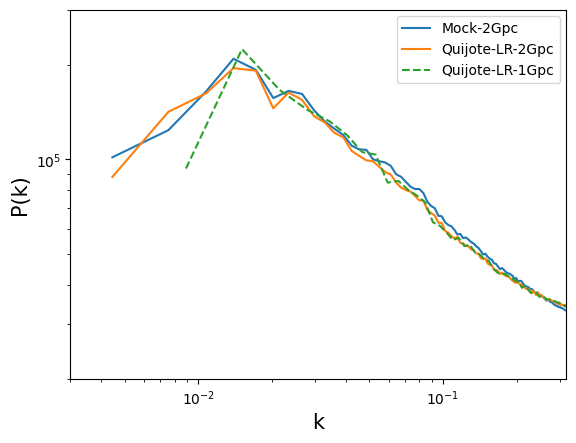

In [44]:
pl.figure()
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='Mock-2Gpc')
pl.plot(Pk_quijote_2gpc.k3D, Pk_quijote_2gpc.Pk[:,0], label='Quijote-LR-2Gpc')
# pl.plot(Pk_quijote_1gpc_HR.k3D, Pk_quijote_1gpc_HR.Pk[:,0],ls = '--', label='Quijote-HR-1Gpc')
pl.plot(Pk_quijote_1gpc_LR.k3D, Pk_quijote_1gpc_LR.Pk[:,0], ls = '--',label='Quijote-LR-1Gpc')

pl.xscale('log')
pl.yscale('log')
pl.xlim(0.003, 0.32)
pl.ylim(2e4, 3e5)
pl.legend()
pl.xlabel('k', size=15)
pl.ylabel('P(k)', size=15)




Text(0, 0.5, 'P(k) Mock/Truth')

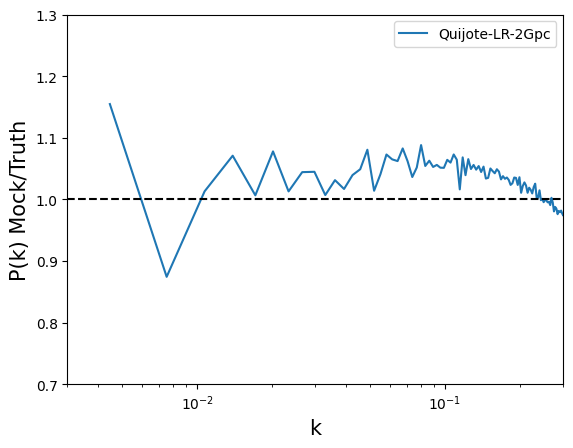

In [42]:
pl.figure()
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='Mock-3Gpc')
pl.plot(Pk_quijote_2gpc.k3D, Pk_mock.Pk[:,0]/Pk_quijote_2gpc.Pk[:,0], label='Quijote-LR-2Gpc')
# pl.plot(Pk_quijote_1gpc_HR.k3D, Pk_quijote_1gpc_HR.Pk[:,0],ls = '--', label='Quijote-HR-1Gpc')
# pl.plot(Pk_quijote_1gpc_LR.k3D, Pk_quijote_1gpc_LR.Pk[:,0], ls = '-.',label='Quijote-LR-1Gpc')

pl.xscale('log')
# pl.yscale('log')
pl.xlim(0.003, 0.3)
pl.axhline(1, ls='--', color='k')
# pl.ylim(2e4, 3e5)
pl.legend()
pl.ylim(0.7, 1.3)
pl.xlabel('k', size=15)
pl.ylabel('P(k) Mock/Truth', size=15)




Text(0, 0.5, 'Number of halos/(Volume)')

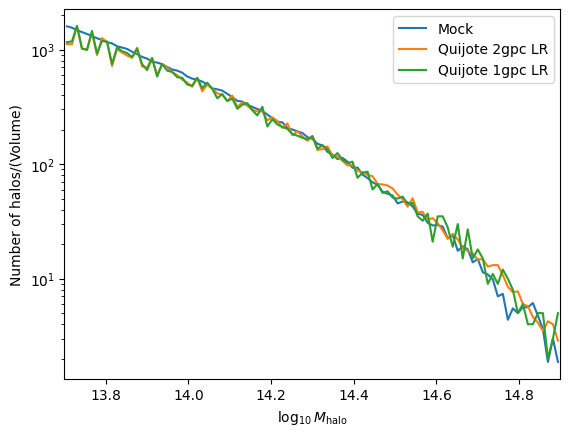

In [45]:
lgMass_edges = np.linspace(13.7, 14.9, 100)
lgMass_bin = 0.5 * (lgMass_edges[1:] + lgMass_edges[:-1])
lgMass_hist_mock, _ = np.histogram(lgMass_mock, bins=lgMass_edges)
lgMass_hist_quijote_2gpc, _ = np.histogram(lgMass_quijote_2gpc, bins=lgMass_edges)
lgMass_hist_quijote_1gpc_HR, _ = np.histogram(lgMass_quijote_1gpc_HR, bins=lgMass_edges)
lgMass_hist_quijote_1gpc_LR, _ = np.histogram(lgMass_quijote_1gpc_LR, bins=lgMass_edges)

vol_mock = 2**3
vol_quijote_2gpc = 2**3
vol_quijote_1gpc_HR = 1**3
vol_quijote_1gpc_LR = 1**3

pl.figure()
# _ = pl.hist(lgMass_mock, bins=100, histtype='step', label='Mock', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_3gpc, bins=100, histtype='step', label='Quijote 3gpc', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_1gpc_HR, bins=100, histtype='step', label='Quijote 1gpc HR', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_1gpc_LR, bins=100, histtype='step', label='Quijote 1gpc LR', range=(13.7, 14.9))
pl.plot(lgMass_bin, lgMass_hist_mock/vol_mock, label='Mock')
pl.plot(lgMass_bin, lgMass_hist_quijote_2gpc/vol_quijote_2gpc, label='Quijote 2gpc LR')
# pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_HR/vol_quijote_1gpc_HR, label='Quijote 1gpc HR')
pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_LR/vol_quijote_1gpc_LR, label='Quijote 1gpc LR')
pl.legend()
pl.yscale('log')
pl.xlim(13.7, 14.9)
pl.xlabel(r'$\log_{10} M_{\rm halo}$')
pl.ylabel('Number of halos/(Volume)')



In [41]:
lgMass_1gpc_all = []
snapnum = 4
for ji in range(1,28):
    snapdir = f'/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial/{ji}/'

    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

    index_pid = header.index('PID')
    id_halo = np.where(rockstar[:,index_pid] == -1)[0]

    pos_h_truth = pos_h_truth[id_halo]
    mass_truth = mass_truth[id_halo]

    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    lgMass_1gpc_all.append(lgMass_truth)

lgMass_1gpc_all = np.concatenate(lgMass_1gpc_all)



/tmp/ipykernel_977720/2415061955.py:21: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


In [42]:
len(lgMass_1gpc_all)


2282621

In [43]:
snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_3Gpc/Rockstar'
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

index_pid = header.index('PID')
id_halo = np.where(rockstar[:,index_pid] == -1)[0]

pos_h_truth = pos_h_truth[id_halo]
mass_truth = mass_truth[id_halo]

lgMass_3gpc_all = np.log10(mass_truth).astype(np.float32)



/tmp/ipykernel_977720/4173107886.py:17: RuntimeWarning: divide by zero encountered in log10
  lgMass_3gpc_all = np.log10(mass_truth).astype(np.float32)


In [44]:
snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_2Gpc/Rockstar'
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

index_pid = header.index('PID')
id_halo = np.where(rockstar[:,index_pid] == -1)[0]

pos_h_truth = pos_h_truth[id_halo]
mass_truth = mass_truth[id_halo]

lgMass_2Gpc_all = np.log10(mass_truth).astype(np.float32)



/tmp/ipykernel_977720/841464876.py:17: RuntimeWarning: divide by zero encountered in log10
  lgMass_2Gpc_all = np.log10(mass_truth).astype(np.float32)


In [45]:
# lgMass_2Gpc_all

(30.0, 3000.0)

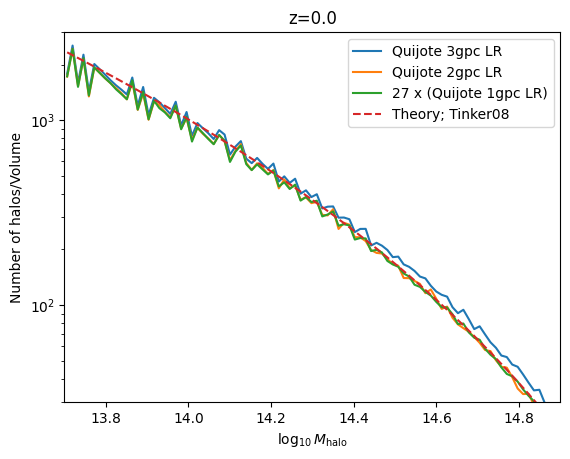

In [47]:
lgMass_edges = np.linspace(13.7, 15.0, 100)
lgMass_bin = 0.5 * (lgMass_edges[1:] + lgMass_edges[:-1])
# lgMass_hist_mock, _ = np.histogram(lgMass_mock, bins=lgMass_edges)
lgMass_hist_quijote_3gpc_all, _ = np.histogram(lgMass_3gpc_all, bins=lgMass_edges)
lgMass_hist_quijote_2gpc_all, _ = np.histogram(lgMass_2Gpc_all, bins=lgMass_edges)
# lgMass_hist_quijote_1gpc_HR, _ = np.histogram(lgMass_quijote_1gpc_HR, bins=lgMass_edges)
lgMass_hist_quijote_1gpc_LR_all, _ = np.histogram(lgMass_1gpc_all, bins=lgMass_edges)

lnMass_edges = np.log(10**lgMass_edges)
dlnMass_bin = lnMass_edges[1] - lnMass_edges[0]
hmf = mass_function.massFunction(10**lgMass_bin, float(0.0), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
N_theory = hmf * dlnMass_bin * (3000)**3

# vol_mock = 3**3
vol_quijote_3gpc = 3**3
vol_quijote_2gpc = 2**3
# vol_quijote_1gpc_HR = 1**3
vol_quijote_1gpc_LR_all = 3**3

pl.figure()
# _ = pl.hist(lgMass_mock, bins=100, histtype='step', label='Mock', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_3gpc, bins=100, histtype='step', label='Quijote 3gpc', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_1gpc_HR, bins=100, histtype='step', label='Quijote 1gpc HR', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_1gpc_LR, bins=100, histtype='step', label='Quijote 1gpc LR', range=(13.7, 14.9))
# pl.plot(lgMass_bin, lgMass_hist_mock/vol_mock, label='Mock')
pl.plot(lgMass_bin, lgMass_hist_quijote_3gpc_all/vol_quijote_3gpc, label='Quijote 3gpc LR')
pl.plot(lgMass_bin, lgMass_hist_quijote_2gpc_all/vol_quijote_2gpc, label='Quijote 2gpc LR')
# pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_HR/vol_quijote_1gpc_HR, label='Quijote 1gpc HR')
pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_LR_all/vol_quijote_3gpc, label='27 x (Quijote 1gpc LR)')
pl.plot(lgMass_bin, N_theory/vol_quijote_3gpc, ls='--', label='Theory; Tinker08')
pl.legend()
pl.yscale('log')
pl.xlim(13.7, 14.9)
pl.xlabel(r'$\log_{10} M_{\rm halo}$')
pl.ylabel('Number of halos/Volume')
pl.title('z=0.0')
# pl.ylim(1e3, 1e5)
# pl.ylim(1e1, 5e3)
pl.ylim(3e1, 3e3)


In [95]:
import readgadget
import readfof

lgMass_1gpc_all = []
snapnum = 4
for ji in range(1,28):
    snapdir = f'/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/fiducial/{ji}'
    FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
    # get the properties of the halos
    # pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
    mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    lgMass_1gpc_all.append(lgMass_truth)

lgMass_1gpc_all = np.concatenate(lgMass_1gpc_all)



In [96]:
# lgMass_1gpc_all

In [97]:
import readgadget
import readfof

lgMass_1gpc_all_ZA = []
# snapnum = 0
for ji in range(1,28):
    snapdir = f'/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/fiducial_ZA/{ji}'
    FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
    # get the properties of the halos
    # pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
    mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    lgMass_1gpc_all_ZA.append(lgMass_truth)

lgMass_1gpc_all_ZA = np.concatenate(lgMass_1gpc_all_ZA)



In [98]:
snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_3Gpc/0'
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
# pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
lgMass_3gpc_all = np.log10(mass_truth).astype(np.float32)





In [99]:
snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_2Gpc/0'
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
# pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
lgMass_2gpc_all = np.log10(mass_truth).astype(np.float32)





(100.0, 4000.0)

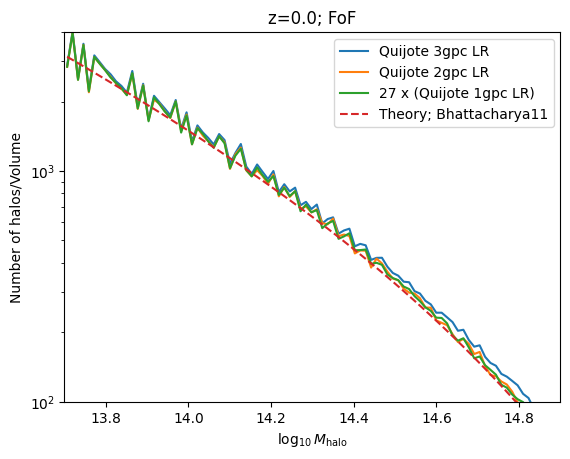

In [102]:
lgMass_edges = np.linspace(13.7, 15.0, 100)
lgMass_bin = 0.5 * (lgMass_edges[1:] + lgMass_edges[:-1])
# lgMass_hist_mock, _ = np.histogram(lgMass_mock, bins=lgMass_edges)
lgMass_hist_quijote_3gpc_all, _ = np.histogram(lgMass_3gpc_all, bins=lgMass_edges)
lgMass_hist_quijote_2gpc_all, _ = np.histogram(lgMass_2gpc_all, bins=lgMass_edges)
# lgMass_hist_quijote_1gpc_HR, _ = np.histogram(lgMass_quijote_1gpc_HR, bins=lgMass_edges)
lgMass_hist_quijote_1gpc_LR_all, _ = np.histogram(lgMass_1gpc_all, bins=lgMass_edges)
lgMass_hist_quijote_1gpc_ZA_LR_all, _ = np.histogram(lgMass_1gpc_all_ZA, bins=lgMass_edges)

lnMass_edges = np.log(10**lgMass_edges)
dlnMass_bin = lnMass_edges[1] - lnMass_edges[0]
hmf = mass_function.massFunction(10**lgMass_bin, float(0.0), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
N_theory = hmf * dlnMass_bin * (3000)**3

# vol_mock = 3**3
vol_quijote_3gpc = 3**3
vol_quijote_2gpc = 2**3
# vol_quijote_1gpc_HR = 1**3
vol_quijote_1gpc_LR_all = 3**3

pl.figure()
# _ = pl.hist(lgMass_mock, bins=100, histtype='step', label='Mock', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_3gpc, bins=100, histtype='step', label='Quijote 3gpc', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_1gpc_HR, bins=100, histtype='step', label='Quijote 1gpc HR', range=(13.7, 14.9))
# _ = pl.hist(lgMass_quijote_1gpc_LR, bins=100, histtype='step', label='Quijote 1gpc LR', range=(13.7, 14.9))
# pl.plot(lgMass_bin, lgMass_hist_mock/vol_mock, label='Mock')
pl.plot(lgMass_bin, lgMass_hist_quijote_3gpc_all/vol_quijote_3gpc, label='Quijote 3gpc LR')
pl.plot(lgMass_bin, lgMass_hist_quijote_2gpc_all/vol_quijote_2gpc, label='Quijote 2gpc LR')
# pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_HR/vol_quijote_1gpc_HR, label='Quijote 1gpc HR')
pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_LR_all/vol_quijote_3gpc, label='27 x (Quijote 1gpc LR)')
# pl.plot(lgMass_bin, lgMass_hist_quijote_1gpc_ZA_LR_all, label='27 x (Quijote 1gpc ZA LR)')
pl.plot(lgMass_bin, N_theory/vol_quijote_3gpc, ls='--', label='Theory; Bhattacharya11')
pl.legend()
pl.yscale('log')
pl.xlim(13.7, 14.9)
pl.xlabel(r'$\log_{10} M_{\rm halo}$')
pl.ylabel('Number of halos/Volume')
pl.title('z=0.0; FoF')
pl.ylim(1e2, 4e3)


Text(0, 0.5, 'Number density of halos')

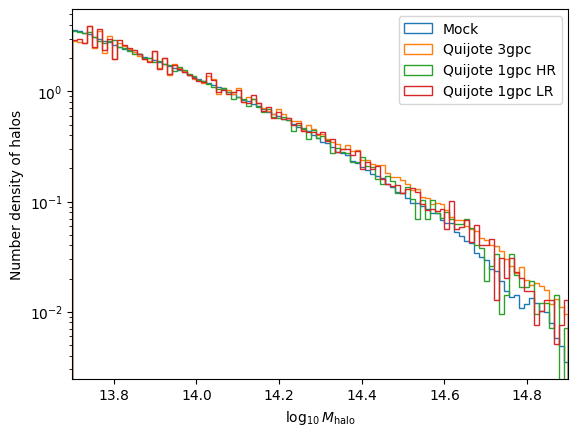

In [21]:
pl.figure()
_ = pl.hist(lgMass_mock, bins=100, histtype='step', label='Mock', range=(13.7, 14.9), density=True)
_ = pl.hist(lgMass_quijote_3gpc, bins=100, histtype='step', label='Quijote 3gpc', range=(13.7, 14.9), density=True)
_ = pl.hist(lgMass_quijote_1gpc_HR, bins=100, histtype='step', label='Quijote 1gpc HR', range=(13.7, 14.9), density=True)
_ = pl.hist(lgMass_quijote_1gpc_LR, bins=100, histtype='step', label='Quijote 1gpc LR', range=(13.7, 14.9), density=True)
pl.legend()
pl.yscale('log')
pl.xlim(13.7, 14.9)
pl.xlabel(r'$\log_{10} M_{\rm halo}$')
pl.ylabel('Number density of halos')



Text(0, 0.5, 'P(k)')

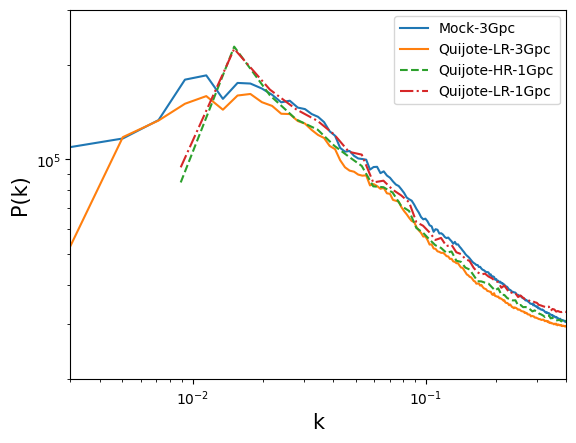

In [13]:

pl.figure()
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='Mock-3Gpc')
pl.plot(Pk_quijote_3gpc.k3D, Pk_quijote_3gpc.Pk[:,0], label='Quijote-LR-3Gpc')
pl.plot(Pk_quijote_1gpc_HR.k3D, Pk_quijote_1gpc_HR.Pk[:,0],ls = '--', label='Quijote-HR-1Gpc')
pl.plot(Pk_quijote_1gpc_LR.k3D, Pk_quijote_1gpc_LR.Pk[:,0], ls = '-.',label='Quijote-LR-1Gpc')

pl.xscale('log')
pl.yscale('log')
pl.xlim(0.003, 0.4)
pl.ylim(2e4, 3e5)
pl.legend()
pl.xlabel('k', size=15)
pl.ylabel('P(k)', size=15)




In [9]:
snapnum = 3
snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/Rockstar'
# Pk_quijote_3gpc = get_Pk_quijote(snap_dir_3gpc, snapnum, grid = 384, BoxSize = 3000.0)

rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

index_pid = header.index('PID')
id_halo = np.where(rockstar[:,index_pid] == -1)[0]

pos_h_truth = pos_h_truth[id_halo]
mass_truth = mass_truth[id_halo]

lgMass_truth = np.log10(mass_truth).astype(np.float32)

indsel = np.where(mass_truth > 10**(lgMmin))[0]
pos_h_truth = pos_h_truth[indsel].astype(np.float32)
lgMass_truth = lgMass_truth[indsel]

mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(pos_h_truth, mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None)



/tmp/ipykernel_852402/433082397.py:20: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


NameError: name 'grid' is not defined

In [13]:
# len(id_halo)/len(rockstar)

#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius PID
#a = 1.000000
#Om = 0.317500; Ol = 0.682500; h = 0.671100
#FOF linking length: 0.280000
#Unbound Threshold: 0.500000; FOF Refinement Threshold: 0.700000
#Particle mass: 6.56561e+11 Msun/h
#Box size: 3000.000000 Mpc/h
#Force resolution assumed: 0.05 Mpc/h
#Units: Masses in Msun / h
#Units: Positions in Mpc / h (comoving)
#Units: Velocities in km / s (physical, peculiar)
#Units: Halo Distances, Lengths, and Radii in kpc / h (comoving)
#Units: Angular Momenta in (Msun/h) * (Mpc/h) * km/s (physical)
#Units: Spins are dimensionless
#Np is an internal debugging quantity.
#Rockstar Version: 0.99.9-RC3+


0.9992339618526805

In [119]:

isim = test_id
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/Rockstar'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 10**(13.7))[0]
pos_h_truth_3gpc = pos_h_truth[indsel]
vel_h_truth_3gpc = vel_h_truth[indsel]
lgMass_truth_3gpc = lgMass_truth[indsel]




/tmp/ipykernel_4068901/1458337577.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


In [120]:

isim = test_id
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR/'
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/Rockstar'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 10**(13.7))[0]
pos_h_truth_1gpc = pos_h_truth[indsel]
vel_h_truth_1gpc = vel_h_truth[indsel]
lgMass_truth_1gpc = lgMass_truth[indsel]




/tmp/ipykernel_4068901/3294445083.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


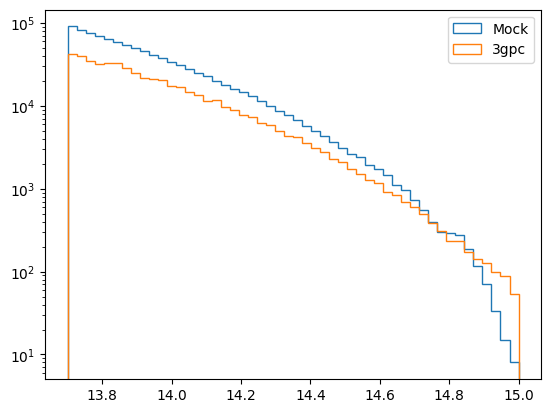

In [121]:
pl.figure()
_ = pl.hist(lgMass_mock, bins=50, histtype='step', label='Mock', range=(13.7, 15.0))
# _ = pl.hist(hmasss[4], bins=50, histtype='step', label='Mock', range=(13.7, 15.5), density=True)
# _ = pl.hist(lgMass_truth_1gpc, bins=50, histtype='step', label='1gpc', range=(13.7, 15.0))
_ = pl.hist(lgMass_truth_3gpc, bins=50, histtype='step', label='3gpc', range=(13.7, 15.0))
pl.legend()
pl.yscale('log')




In [122]:
import Pk_library as PKL
import MAS_library as MASL

grid = 384
sigma_lgM = 0.2
alpha = 0.0
nbar = 4e-4
sat_frac = 0.2
BoxSize = 3000.0 #Mpc/h ; size of box
Mmin_Pk = 13.7
Mmax_Pk = 15.0
threads = 1
M1 = 14.0
MAS = 'NGP'

indsel_Pk_truth = np.where((lgMass_truth_3gpc > Mmin_Pk) & (lgMass_truth_3gpc < Mmax_Pk))[0]
mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (pos_h_truth_3gpc[indsel_Pk_truth,...]).astype(np.float32)
W_truth = (10**lgMass_truth_3gpc[indsel_Pk_truth]/10**M1)**(alpha)
# MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth[indsel_Pk_truth]- Mmax_Pk)))
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=W_truth)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=threads)

indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
W_mock = (10**lgMass_mock[indsel_Pk_mock]/10**M1)**(alpha)
# MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock[indsel_Pk_mock]- Mmax_Pk)))
MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=W_mock)
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=threads)




Computing power spectrum of the field...
Time to complete loop = 1.80
Time taken = 2.45 seconds

Computing power spectrum of the field...
Time to complete loop = 1.82
Time taken = 2.48 seconds


In [123]:
indsel_Pk_truth = np.where((lgMass_truth_1gpc > Mmin_Pk) & (lgMass_truth_1gpc < Mmax_Pk))[0]
mesh_truth1 = np.zeros((grid//3, grid//3, grid//3), dtype=np.float32)
pos_truth1 = (pos_h_truth_1gpc[indsel_Pk_truth,...]).astype(np.float32)
W_truth = (10**lgMass_truth_1gpc[indsel_Pk_truth]/10**M1)**(alpha)
# MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth[indsel_Pk_truth]- Mmax_Pk)))
MASL.MA(pos_truth1, mesh_truth1, BoxSize//3, MAS, W=W_truth)
mesh_truth1 /= np.mean(mesh_truth1, dtype=np.float64);  mesh_truth1 -= 1.0
Pk_truth1 = PKL.Pk(mesh_truth1, BoxSize//3, axis=0, MAS=None, threads=threads)




Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [124]:
# len(pos_h_mock), len(pos_h_truth_3gpc), len(pos_h_truth_1gpc)
# 



In [125]:
# pl.figure()
# pl.scatter(pos_h_mock[::100,0], pos_h_mock[::100,1], s=0.4)


In [126]:
# pl.figure()
# pl.scatter(pos_h_truth_3gpc[::100,0], pos_h_truth_3gpc[::100,1], s=0.4)



Text(0, 0.5, 'P(k)')

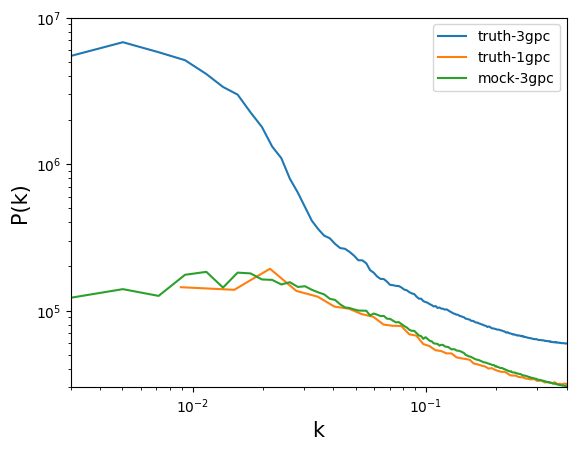

In [137]:
pl.figure()
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='truth-3gpc')
pl.plot(Pk_truth1.k3D, Pk_truth1.Pk[:,0], label='truth-1gpc')
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='mock-3gpc')
pl.xscale('log')
pl.yscale('log')
pl.xlim(0.003, 0.4)
pl.ylim(3e4, 1e7)
pl.legend()
pl.xlabel('k', size=15)
pl.ylabel('P(k)', size=15)




In [13]:
# df_rho_3gpc = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/3gpc/0/density_HR_full_m_res_384_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk','rb'))['density_cic_unpad_combined']
# df_rho_1gpc_hr = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/1/density_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk','rb'))['density_cic_unpad_combined']
# df_3gpc = 
import numpy as np
import readgadget

# input files
snapshot = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/0/snapdir_003/snap_003'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h



In [14]:
grid = 384
BoxSize = 3000.0
MAS = 'CIC'
mesh_3gpc = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(pos, mesh_3gpc, BoxSize, MAS)
mesh_3gpc /= np.mean(mesh_3gpc, dtype=np.float32);  mesh_3gpc -= 1.0
Pk_mm_3gpc = PKL.Pk(mesh_3gpc, BoxSize, axis=0, MAS=None)





Computing power spectrum of the field...
Time to complete loop = 1.73
Time taken = 2.36 seconds


In [15]:
import numpy as np
import readgadget

# input files
snapshot = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial_HR/1/snapdir_003/snap_003'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h

grid = 128
BoxSize = 1000.0
MAS = 'CIC'
mesh_1gpc = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(pos, mesh_1gpc, BoxSize, MAS)
mesh_1gpc /= np.mean(mesh_1gpc, dtype=np.float32);  mesh_1gpc -= 1.0
Pk_mm_1gpc_HR = PKL.Pk(mesh_1gpc, BoxSize, axis=0, MAS=None)





Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [16]:
import numpy as np
import readgadget

# input files
snapshot = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial/1/snapdir_003/snap_003'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h

grid = 128
BoxSize = 1000.0
MAS = 'CIC'
mesh_1gpc = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(pos, mesh_1gpc, BoxSize, MAS)
mesh_1gpc /= np.mean(mesh_1gpc, dtype=np.float32);  mesh_1gpc -= 1.0
Pk_mm_1gpc_LR = PKL.Pk(mesh_1gpc, BoxSize, axis=0, MAS=None)





Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds


Text(0, 0.5, 'P(k)')

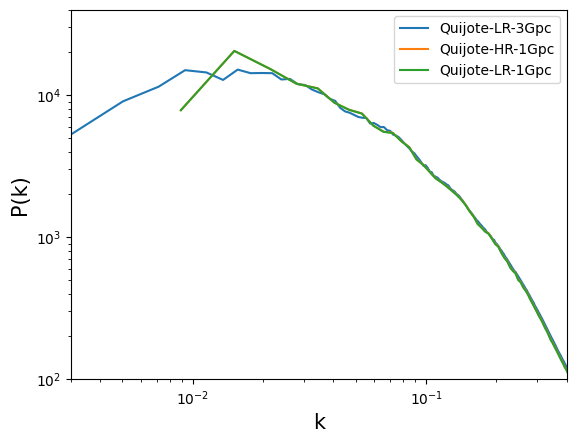

In [21]:
pl.figure()
pl.plot(Pk_mm_3gpc.k3D, Pk_mm_3gpc.Pk[:,0], label='Quijote-LR-3Gpc')
pl.plot(Pk_mm_1gpc_HR.k3D, Pk_mm_1gpc_HR.Pk[:,0], label='Quijote-HR-1Gpc')
pl.plot(Pk_mm_1gpc_LR.k3D, Pk_mm_1gpc_LR.Pk[:,0], label='Quijote-LR-1Gpc')

pl.xscale('log')
pl.yscale('log')
pl.xlim(0.003, 0.4)
pl.ylim(1e2, 4e4)
pl.legend()
pl.xlabel('k', size=15)
pl.ylabel('P(k)', size=15)

